In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
from crocoddylData import *
from Networks import *
from UniTerminal import *
from termData import *

In [3]:
# Get base data

x, x_ref = base_data()
print(x.shape, x_ref.shape)

torch.Size([1000, 3]) torch.Size([1000, 3])


In [4]:
# Generate a neural network
xNet = xRefNet(x.shape[1], x_ref.shape[1])

# Train this net
xNet_trained_on_croc_data = train_xrefNet(xNet, x, x_ref)

100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


In [5]:
# Generate terminal data. This will be Ipera 1.
states, ref_states = terminalData(xNet_trained_on_croc_data)

xNet_trained_on_terminal_data = train_xrefNet(xNet_trained_on_croc_data, states, ref_states)

100%|██████████| 100/100 [03:25<00:00,  2.05s/it]


In [6]:

        
import crocoddyl
import numpy as np
from UniTerminal import *
from tqdm import tqdm

model = crocoddyl.ActionModelUnicycle()
model.costWeights = np.matrix([1,1]).T
xNet_trained_on_terminal_data.eval()
terminalModel = UnicycleTerminal(xNet_trained_on_terminal_data)

positions = []
croc_xs = []
croc_cost = []
croc_iters = []

torch_predictions = []

ddp_with_net_xs = []
ddp_with_net_cost = []
ddp_with_net_iters = []
for _ in tqdm(range(1000)):
    x0 = np.array([np.random.uniform(-2.1, 2.1), np.random.uniform(-2.1, 2.1), np.random.uniform(0,1)])
    T = 30
    positions.append(x0)
    problem = crocoddyl.ShootingProblem(x0.T, [ model ] * T, model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve()
    croc_xs.append(ddp.xs[-1].tolist())
    croc_cost.append(np.array([ddp.cost]))
    croc_iters.append(np.array([ddp.iter]))
    
    test = torch.as_tensor(x0, device = device, dtype = torch.float32).resize_(1, 3)
    prediction = xNet_trained_on_terminal_data(test)
    torch_predictions.append(prediction)
    
    
    problem2 = crocoddyl.ShootingProblem(x0.T, [ model ] * T, terminalModel)
    ddp2 = crocoddyl.SolverDDP(problem2)
    ddp2.solve()
    ddp_with_net_xs.append(ddp2.xs[-1].tolist())
    ddp_with_net_cost.append(np.array([ddp2.cost]))
    ddp_with_net_iters.append(np.array([ddp2.iter]))

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


In [7]:
    
positions = np.array(positions)
croc_xs = np.array(croc_xs)
croc_cost = np.array(croc_cost)
croc_iters = np.array(croc_iters)

torch_predictions = np.array(torch_predictions)

ddp_with_net_xs = np.array(ddp_with_net_xs)
ddp_with_net_cost = np.array(ddp_with_net_cost)
ddp_with_net_iters = np.array(ddp_with_net_iters)    

In [8]:
torch_predicted_xref = []
for a in torch_predictions:
    b = a.cpu().detach().numpy()
    torch_predicted_xref.append(b)
    
torch_predicted_xref = np.squeeze(np.array(torch_predicted_xref))

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
c_xs_VS_t_p_xs_mse = mean_squared_error(croc_xs, torch_predicted_xref)
c_xs_VS_t_p_xs_mae = mean_absolute_error(croc_xs, torch_predicted_xref)
c_xs_VS_t_p_xs_r2 = r2_score(croc_xs, torch_predicted_xref)


c_cost_VS_ddp_net_cost_mse = mean_squared_error(croc_cost, ddp_with_net_cost)
c_cost_VS_ddp_net_cost_mae = mean_absolute_error(croc_cost, ddp_with_net_cost)
c_cost_VS_ddp_net_cost_r2 = r2_score(croc_cost, ddp_with_net_cost)


c_iters_VS_ddp_net_iters_mae = mean_absolute_error(croc_iters, ddp_with_net_iters)
c_iters_VS_ddp_net_iters_mse = mean_squared_error(croc_iters, ddp_with_net_iters)
c_iters_VS_ddp_net_iters_r2 = r2_score(croc_iters, ddp_with_net_iters)

c_xs_VS_ddp_xs_mse = mean_squared_error(croc_xs, ddp_with_net_xs)
c_xs_VS_ddp_xs_mae = mean_absolute_error(croc_xs, ddp_with_net_xs)
c_xs_VS_ddp_xs_r2 = r2_score(croc_xs, ddp_with_net_xs)

In [20]:
print(c_cost_VS_ddp_net_cost_mse) 
print(c_cost_VS_ddp_net_cost_mae) 
print(c_cost_VS_ddp_net_cost_r2)

0.06642523581114383
0.1958769989361458
0.9997538555941026


In [21]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
%matplotlib inline

def plot_(x, y, z, name, label):

    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower")
    plt.xticks(np.arange(-3, 3.1, step=1))
    plt.yticks(np.arange(-3, 3.1, step=1))
    clb = plt.colorbar()
    clb.set_label(label, labelpad=-40, y=1.10, rotation=0)
    plt.title(name)
    plt.savefig(f"{name + label}.png")
    plt.show()

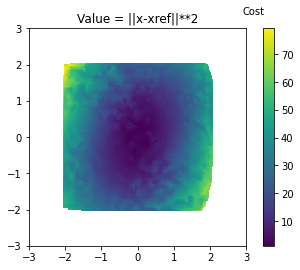

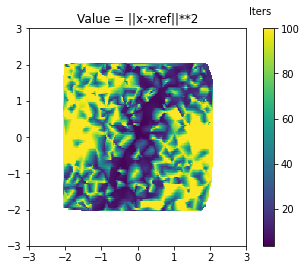

In [22]:
# For the xref network
plot_(x = positions[:,0],
      y = positions[:,1],
      z = ddp_with_net_cost[:,0], 
      name="Value = ||x-xref||**2",
      label ="Cost")
plot_(x = positions[:,0],
      y = positions[:,1], 
      z = ddp_with_net_iters[:,0],
      name="Value = ||x-xref||**2",
      label = "Iters")


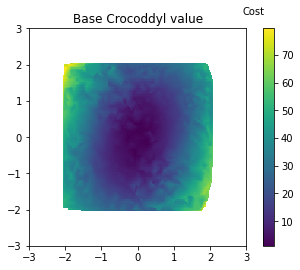

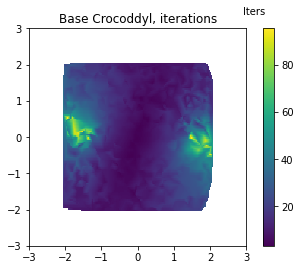

In [13]:
plot_(x = positions[:,0],
      y = positions[:,1],
      z = croc_cost[:,0], 
      name="Base Crocoddyl value",
      label ="Cost")
plot_(x = positions[:,0],
      y = positions[:,1], 
      z = croc_iters[:,0],
      name="Base Crocoddyl, iterations",
      label = "Iters")
